In [1]:
#Purpose: import from other notebook...
#Ref: http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
#--------------------------------------------------------------------------------
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
#--------------------------------------------------------------------------------
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
#--------------------------------------------------------------------------------
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
#--------------------------------------------------------------------------------
sys.meta_path.append(NotebookFinder())

In [2]:
ls

gradient_descent.ipynb          LICENSE               statistics.ipynb
hypothesis_and_inference.ipynb  linear_algebra.ipynb  visualizing_data.ipynb
Importing Notebooks.ipynb       probability.ipynb
__init__.py                     README.md


importing Jupyter notebook from linear_algebra.ipynb


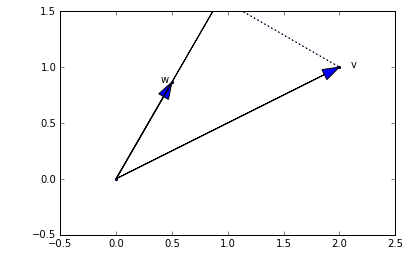

In [3]:
from collections import Counter
from linear_algebra import distance, vector_subtract, scalar_multiply
import math, random
#--------------------------------------------------------------------------------
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)
#--------------------------------------------------------------------------------
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h
#--------------------------------------------------------------------------------
def plot_estimated_derivative():

    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

    # plot to show they're basically the same
    import matplotlib.pyplot as plt
    x = range(-10,10)
    plt.plot(x, map(derivative, x), 'rx')           # red  x
    plt.plot(x, map(derivative_estimate, x), 'b+')  # blue +
    plt.show()                                      # purple *, hopefully
#--------------------------------------------------------------------------------
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]
         
    return (f(w) - f(v)) / h
#--------------------------------------------------------------------------------
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)] 
#--------------------------------------------------------------------------------
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]
#--------------------------------------------------------------------------------
def sum_of_squares_gradient(v): 
    return [2 * v_i for v_i in v]
#--------------------------------------------------------------------------------
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f
#--------------------------------------------------------------------------------

#
# 
# minimize / maximize batch
#
#

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing
    
    while True:
        gradient = gradient_fn(theta)  
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
                   
        # choose the one that minimizes the error function        
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
#--------------------------------------------------------------------------------
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)
#--------------------------------------------------------------------------------    
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]
#--------------------------------------------------------------------------------
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0, 
                          tolerance)
#--------------------------------------------------------------------------------
#
# minimize / maximize stochastic
#

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]
#--------------------------------------------------------------------------------
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = zip(x, y)
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points        
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta
#--------------------------------------------------------------------------------
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)

In [4]:
if __name__ == "__main__":

    print("using the gradient")

    v = [random.randint(-10,10) for i in range(3)]

    tolerance = 0.0000001

    while True:
        print(v, sum_of_squares(v))
        gradient = sum_of_squares_gradient(v)   # compute the gradient at v
        next_v = step(v, gradient, -0.01)       # take a negative gradient step
        if distance(next_v, v) < tolerance:     # stop if we're converging
            break
        v = next_v                              # continue if we're not

    print("minimum v", v)
    print("minimum value", sum_of_squares(v))
    print()


    print("using minimize_batch")

    v = [random.randint(-10,10) for i in range(3)]

    v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

    print("minimum v", v)
    print("minimum value", sum_of_squares(v))

using the gradient
[-7, -2, 9] 134
[-6.86, -1.96, 8.82] 128.6936
[-6.7228, -1.9208, 8.643600000000001] 123.59733344000001
[-6.588344, -1.882384, 8.470728000000001] 118.70287903577602
[-6.45657712, -1.84473632, 8.301313440000001] 114.0022450259593
[-6.327445577600001, -1.8078415936, 8.135287171200002] 109.48775612293132
[-6.200896666048001, -1.771684761728, 7.972581427776001] 105.15204098046323
[-6.076878732727041, -1.73625106649344, 7.813129799220481] 100.98802015763688
[-5.9553411580725, -1.7015260451635712, 7.656867203236072] 96.98889455939447
[-5.83623433491105, -1.6674955242602998, 7.50372985917135] 93.14813433484244
[-5.71950964821283, -1.6341456137750938, 7.353655261987923] 89.45946821518268
[-5.605119455248573, -1.601462701499592, 7.206582156748165] 85.91687327386146
[-5.493017066143602, -1.5694334474696001, 7.062450513613202] 82.51456509221656
[-5.383156724820729, -1.538044778520208, 6.921201503340938] 79.24698831456477
[-5.275493590324315, -1.5072838829498039, 6.78277747327411